# Pooling
:label:`ch_pooling_cpu`

In this section, we will optimize the vector add defined in :numref:`ch_pooling` on CPU.


In [1]:
%matplotlib inline
import d2ltvm
import inspect
from IPython import display
import numpy as np
from matplotlib import pyplot as plt
import timeit
import tvm
from tvm import te

# target = 'llvm -mcpu=skylake-avx512'
target = 'llvm'

## Max Pooling

### Schedule
By now, you should be familiar with the basic optimization tricks that we can do on CPU. Let's print out the IR of `max pooling` again to observe.


In [2]:
# channel, input height and width, kernel height and width
size = (64, 64, 3)

def default_max(size):
    c, n, k = size[:]
    X, Y, PaddedX = d2ltvm.pool('max', c, n, n, k, k, 1, 1, 1, 1)
    sch = te.create_schedule(Y.op)
    return sch, (X, Y)

sch, args = default_max(size)
print(tvm.lower(sch, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer((64, 64, 64), "float32"), PoolMax: T.Buffer((64, 64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        PaddedX = T.allocate([278784], "float32", "global")
        PaddedX_1 = T.Buffer((278784,), data=PaddedX)
        for i0, i1, i2 in T.grid(64, 66, 66):
            X_1 = T.Buffer((262144,), data=X.data)
            PaddedX_1[i0 * 4356 + i1 * 66 + i2] = T.if_then_else(i1 < 1 or i1 == 65 or i2 < 1 or i2 == 65, T.float32(-340282346638528859811704183484516925440.0), X_1[i0 * 4096 + i1 * 64 + i2 - 65])
        for c, h, w in T.grid(64, 64, 64):
            PoolMax_1 = T.Buffer((262144,), data=PoolMax.data)
            PoolMax_1[c * 4096 + h * 64 + w] = T.float32(-340282346638528859811704183484516925440.0)
            for rkh, rkw in T.grid(3, 3):
                cse_var_1: T.int32 = c * 4

You may have already figured out we can do some vectorization and parallelization for the outer loops. As `pooling` is a memory-bound operator, we don't have much to do for optimizing the cache.

However, there is one more thing that we can optimize. Note that the compute of `PoolMax` takes `PaddedX` as the input, which is the output of last compute. We can compute `PaddedX` inline in the stage of `PoolMax` by `te.schedule.AutoInlineInjective(sch)`. Doing this would prevent data from writing to and then reading from `PaddedX`. The simple scheduling is as follows.


In [3]:
def optimized_max(size):
    sch, (X, Y) = default_max(size)
    te.schedule.AutoInlineInjective(sch)
    c, h, w = Y.op.axis[0:3]
    fused = sch[Y].fuse(c, h)
    sch[Y].parallel(fused)
    sch[Y].vectorize(w)
    return sch, (X, Y)

sch, args = optimized_max(size)
print(tvm.lower(sch, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer((64, 64, 64), "float32"), PoolMax: T.Buffer((64, 64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for c_h_fused in T.parallel(4096):
            PoolMax_1 = T.Buffer((262144,), data=PoolMax.data)
            PoolMax_1[c_h_fused * 64:c_h_fused * 64 + 64] = T.Broadcast(T.float32(-340282346638528859811704183484516925440.0), 64)
            for rkh, rkw, w_s in T.grid(3, 3, 64):
                cse_var_4: T.int32 = c_h_fused * 64
                cse_var_3: T.int32 = w_s + rkw
                cse_var_2: T.int32 = rkh + c_h_fused % 64
                cse_var_1: T.int32 = cse_var_4 + w_s
                X_1 = T.Buffer((262144,), data=X.data)
                PoolMax_1[cse_var_1] = T.max(PoolMax_1[cse_var_1], T.if_then_else(cse_var_2 < 1 or cse_var_2 == 65 or cse_var_3 < 1 or cse_var_3 ==

The optimized IR does both the parallelization and vectorization.

### Benchmarking

We now benchmark the default and optimized scheduling of `max pooling`. In order to do this, we first define the benchmarking method of pooling. It is analogous to the benchmarking methods we defined in for other operators before. The main difference is that as `pooling` performs little computation, we use execution time instead of FLOPs to benchmark the results.


In [4]:
channels = 2**np.arange(4, 9)
# a list of (c, n, k)
sizes = [(int(c), 64, 3) for c in channels]

# Save to the d2ltvm package.
def bench_pooling_tvm(func, sizes, target):
    """Benchmark pooling in TVM
    
    func : the scheduling method
    sizes : the data size list, each of which is a (channel, input_hw, kernel_hw) triplet
    target : the TVM target, e.g. llvm or cuda
    """
    def workload(nrepeats):
        timer = mod.time_evaluator(mod.entry_name, dev=ctx, number=nrepeats)
        return timer(data, out_max).mean * nrepeats
    times = []
    for size in sizes:
        sch, args = func(size)
        mod = tvm.build(sch, args, target)
        ctx = tvm.device(target, 0)
        data, _, out_max = d2ltvm.get_conv_data(size[0], size[0], size[1], size[2], 1, 1, 
                                                lambda x: tvm.nd.array(x, device=ctx))
        times.append(d2ltvm.bench_workload(workload))
    return np.array(times)

default_max_times = bench_pooling_tvm(default_max, sizes, target)
optimized_max_times = bench_pooling_tvm(optimized_max, sizes, target)

Then we define the benchmarking method to perform pooling in MXNet. Like the TVM pooling benchmarking method, we collect execution time instead of FLOPs.


In [5]:
# Save to the d2ltvm package.
def pooling_timer_mxnet(pool_type, c, n, k, ctx):
    """Benchmark pooling in MXNet

    c : channels
    n : input width and height
    k : kernel width and height
    """
    timer = timeit.Timer(
        setup='import d2ltvm\n'
        'import mxnet as mx\n'
        'c, n, k, p, s = %d, %d, %d, 1, 1\n'
        'data, out = d2ltvm.get_pool_data_mxnet(\n'
        '    c, n, k, p, s, "%s")'%(c, n, k, ctx),
        stmt='d2ltvm.pool_mxnet("%s", data, out, k, p, s);'
        'out.wait_to_read()'%(pool_type))
    return timer.timeit

# Save to the d2ltvm package.
def bench_pooling_mxnet(pool_type, sizes, ctx='cpu'):
    """Return the execution times of MXNet pooling"""
    return [d2ltvm.bench_workload(pooling_timer_mxnet(pool_type, c, n, k, ctx))
            for c, n, k in sizes]

mxnet_max_times = bench_pooling_mxnet('max', sizes)

Then we plot the results to compare. Note that we are plotting the execution time, so lower is better.


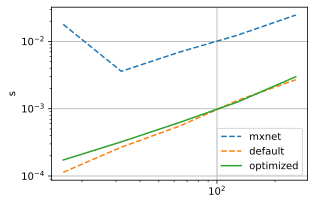

In [6]:
times = [mxnet_max_times, default_max_times, optimized_max_times]
d2ltvm.plot(channels, times, ylabel='s',
            xscale='log', yscale='log',
            legend=['mxnet', 'default', 'optimized'], fmts=['--']*(len(times)-1)+['-'])

From the diagram we see that even using the default schedule, TVM outperforms MXNet significantly. This is because the pooling runs very fast, making the function call overhead of MXNet discussed in :numref:`ch_call_overhead` profound.

## Avg Pooling

### Schedule
Now let's move to `avg pooling`. Again, we print out the IR of `avg pooling` to observe.


In [7]:
def default_avg(size):
    c, n, k = size[:]
    X, Y, PaddedX = d2ltvm.pool('avg', c, n, n, k, k, 1, 1, 1, 1)
    sch = te.create_schedule(Y.op)
    return sch, (X, Y)

sch, args = default_avg(size)
print(tvm.lower(sch, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer((64, 64, 64), "float32"), PoolAvg: T.Buffer((64, 64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        PaddedX = T.allocate([278784], "float32", "global")
        PoolSum = T.allocate([262144], "float32", "global")
        PaddedX_1 = T.Buffer((278784,), data=PaddedX)
        for i0, i1, i2 in T.grid(64, 66, 66):
            X_1 = T.Buffer((262144,), data=X.data)
            PaddedX_1[i0 * 4356 + i1 * 66 + i2] = T.if_then_else(i1 < 1 or i1 == 65 or i2 < 1 or i2 == 65, T.float32(0.0), X_1[i0 * 4096 + i1 * 64 + i2 - 65])
        PoolSum_1 = T.Buffer((262144,), data=PoolSum)
        for c, h, w in T.grid(64, 64, 64):
            PoolSum_1[c * 4096 + h * 64 + w] = T.float32(0.0)
            for rkh, rkw in T.grid(3, 3):
                cse_var_1: T.int32 = c * 4096 + h * 64 + w
          

Similarly, we can do parallelization, vectorization, and merging stages of `PaddedX` and `PoolSum` using `te.schedule.AutoInlineInjective(sch)`. 
In addition, we want to compute an element of `PoolAvg` right after getting the corresponding element of `PoolSum`, so that we can immediately use `PoolSum` after it is produced. This can be realized by the `compute_at()` scheduling premitive. 
As a side note, there is another compiling optimization already done in the default scheduling, which is converting the division operation into multiplying the reciprocal of the divisor. In this case, it converts dividing $9$ into multiplying $0.111111$. The reason is that the division instruction in the processor is much more expensive than the multiplication instruction.


In [8]:
def schedule_avg(size):
    sch, (X, Y) = default_avg(size)
    te.schedule.AutoInlineInjective(sch)
    c, h, w = Y.op.axis[0:3]
    fused = sch[Y].fuse(c, h)
    sch[Y].parallel(fused)
    sch[Y].vectorize(w)
    PoolSum = Y.op.input_tensors[0]
    sch[PoolSum].compute_at(sch[Y], Y.op.axis[2])
    return sch, (X, Y)

sch, args = schedule_avg(size)
print(tvm.lower(sch, args, simple_mode=True))

# from tvm.script import ir as I
# from tvm.script import tir as T

@I.ir_module
class Module:
    @T.prim_func
    def main(X: T.Buffer((64, 64, 64), "float32"), PoolAvg: T.Buffer((64, 64, 64), "float32")):
        T.func_attr({"from_legacy_te_schedule": T.bool(True), "tir.noalias": T.bool(True)})
        for c_h_fused in T.parallel(4096):
            PoolSum = T.allocate([64], "float32", "global")
            PoolSum_1 = T.Buffer((64,), data=PoolSum, align=4)
            PoolSum_1[0:64] = T.Broadcast(T.float32(0.0), 64)
            for rkh, rkw, w_s in T.grid(3, 3, 64):
                cse_var_2: T.int32 = w_s + rkw
                cse_var_1: T.int32 = rkh + c_h_fused % 64
                PoolSum_2 = T.Buffer((64,), data=PoolSum, align=4)
                PoolSum_3 = T.Buffer((64,), data=PoolSum, align=4)
                X_1 = T.Buffer((262144,), data=X.data)
                PoolSum_2[w_s] = PoolSum_3[w_s] + T.if_then_else(cse_var_1 < 1 or cse_var_1 == 65 or cse_var_2 < 1 or cse_var_2

From the optimized IR we can see that the stage of `PoolSum` is merged into the stage of `PoolAvg`, which produces better data locality.

### Benchmarking

We now benchmark the default and optimized scheduling of `avg pooling`, as well as the MXNet performance.


In [9]:
default_avg_times = bench_pooling_tvm(default_avg, sizes, target)
schedule_avg_times = bench_pooling_tvm(schedule_avg, sizes, target)

mxnet_avg_times = bench_pooling_mxnet('avg', sizes)

Then we plot the results to compare. Again, as we are plotting the execution time, lower is better.


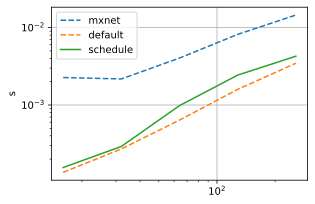

In [10]:
times = [mxnet_avg_times, default_avg_times, schedule_avg_times]
d2ltvm.plot(channels, times, ylabel='s',
            xscale='log', yscale='log',
            legend=['mxnet', 'default', 'schedule'], fmts=['--']*(len(times)-1)+['-'])

From the diagram we see similar behavior as the `max pooling` operator.

Overall, we see that `pooling` only takes a negeligible amount of time. So it is normally not a focus in optimizing deep learning workloads.

Another interesting optimization idea of `pooling` is to fuse it to other operators like `convolution`. Theoretically, this can result in better data locality. However, this is not easy to implement as the reduction operation in `pooling` introduces dependencies, i.e. a specific set of data should be ready before the `pooling` can be executed. Handling this dependency in other operators is tedious. In practice, only on specialized accelerators where all memory movement is managed explicitly, the compiler would perform operator fusion between `pooling` and others.

## Summary

- Pooling can be optimized on CPUs via parallelization and vectorization.
- The padding stage can be computed inline in the latter stage using `AutoInlineInjective`.
- We can use `compute_at` scheduling premitive to merge stages for better data locality.
